# Structure of the notebook 

### I. Feature engineering.

#### 1) Difference between off-peak prices in December and preceding January.
#### 2). Getting time related features.
#### 3). Getting consumption based features.

### II. Choosing the evaluation metric and treatment of outliers..

#### 1). The choice of the evaluation metric.
#### 2). Handling outliers.

###  III. Correlation based feature selection.

###  IV. Tuning and training the Random Forest model.

#### 1). The reasons why the Random Forest model is a good choice for our case.
#### 2). Tuning and training the model.
#### 3). Evaluating of the model.

### V. Model interpretation using SHAP






In [3]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import OrdinalEncoder
from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.encoding import MeanEncoder
from feature_engine.encoding import PRatioEncoder
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection
from feature_engine.wrappers import SklearnTransformerWrapper
import optuna
import shap
import pickle


In [4]:
df = pd.read_csv('clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [5]:
df.head(3)

,Unnamed: 0,id,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,churn,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,forcasted_price,previous_price,price_sens
0,0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,1,0.124787,0.100749,0.06653,40.942265,22.35201,14.90134,0.106312,0.112768,NaN
1,1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0,0.149609,0.007124,0.00000,44.311375,0.00000,0.00000,0.072855,0.078366,13.640956
2,2,764c75f661154dac3a6c254cd082ea7d,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0,0.170512,0.088421,0.00000,44.385450,0.00000,0.00000,0.126847,0.129466,45.058910


In [6]:
df = df.drop('Unnamed: 0', axis=1)
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,...,churn,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,forcasted_price,previous_price,price_sens
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,...,1,0.124787,0.100749,0.066530,40.942265,22.352010,14.901340,0.106312,0.112768,NaN
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,...,0,0.149609,0.007124,0.000000,44.311375,0.000000,0.000000,0.072855,0.078366,13.640956
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,...,0,0.170512,0.088421,0.000000,44.385450,0.000000,0.000000,0.126847,0.129466,45.058910
3,bba03439a292a1e166f80264c16191cb,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,...,0,0.151210,0.000000,0.000000,44.400265,0.000000,0.000000,0.073347,0.075605,28.408609
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,...,0,0.124174,0.103638,0.072865,40.688156,24.412893,16.275263,0.108457,0.113906,18.799168


### I. Feature engineering

#### 1). Difference between off-peak prices in December and preceding January


In [7]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14542 entries, 0 to 14541
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              14542 non-null  object        
 1   cons_12m                        14542 non-null  int64         
 2   cons_gas_12m                    14542 non-null  int64         
 3   cons_last_month                 14542 non-null  int64         
 4   date_activ                      14542 non-null  datetime64[ns]
 5   date_end                        14542 non-null  datetime64[ns]
 6   date_modif_prod                 14542 non-null  datetime64[ns]
 7   date_renewal                    14542 non-null  datetime64[ns]
 8   forecast_cons_12m               14542 non-null  float64       
 9   forecast_cons_year              14542 non-null  int64         
 10  forecast_discount_energy        14542 non-null  float64       
 11  fo

In [9]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


#### Exploiting the difference between prices to improve the model’s predictive power.

We can exploit this feature by generating a new categorical feature that indicates if the price increased, decreased or did not change during the last year. there is two reasons why this is a useful thing to do:

- Categorical variables are generally more easy to interpret.
- We can encode this feature using powerful techniques that can add more predictive power to our model such as mean encoding which creates a monotonic relationship between the variable and the target. This monotonic relationship implies that if the value of one variable increases/decreases so does the value of the other variable. .

In [10]:
# A function to create the new feature "price_change"

def price_change(x):
    if x > 0:
        return 'increase'
    elif x < 0:
        return 'decrease'
    else:
        return 'stable'
    

In [11]:
# Merging with the main dataset
new_df_ft = df.merge(diff, how='left', left_on='id', right_on='id')
new_df_ft.head()

,id,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,...,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,forcasted_price,previous_price,price_sens,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,...,0.100749,0.066530,40.942265,22.352010,14.901340,0.106312,0.112768,NaN,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,...,0.007124,0.000000,44.311375,0.000000,0.000000,0.072855,0.078366,13.640956,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,...,0.088421,0.000000,44.385450,0.000000,0.000000,0.126847,0.129466,45.058910,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,...,0.000000,0.000000,44.400265,0.000000,0.000000,0.073347,0.075605,28.408609,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,...,0.103638,0.072865,40.688156,24.412893,16.275263,0.108457,0.113906,18.799168,-0.006192,0.162916


In [12]:
# Creating the new categorical features
new_df_ft['price_change_energy'] = new_df_ft['offpeak_diff_dec_january_energy'].apply(price_change)
new_df_ft['price_change_power'] = new_df_ft['offpeak_diff_dec_january_power'].apply(price_change)

In [13]:
# Dropping the first feature 
new_df_ft = new_df_ft.drop(['offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power'], axis=1)


#### 2). Getting time related features

In [14]:
# Getting the activation year 
new_df_ft['activ_year'] = new_df_ft['date_activ'].dt.year

# Getting the activation month 
new_df_ft['activ_month'] = new_df_ft['date_activ'].dt.month

# Getting the ending year
new_df_ft['end_year'] = new_df_ft['date_end'].dt.year

# Getting the ending month 
new_df_ft['end_month'] = new_df_ft['date_end'].dt.month

# Getting the year of the last modification of the product 
new_df_ft['modif_prod_year'] = new_df_ft['date_modif_prod'].dt.year

# Getting the month of the last modification of the product 
new_df_ft['modif_prod_month'] = new_df_ft['date_modif_prod'].dt.month

# Getting the renewal year
new_df_ft['renewal_year'] = new_df_ft['date_renewal'].dt.year

# Getting the renewal month 
new_df_ft['renewal_month'] = new_df_ft['date_renewal'].dt.month

# Difference between activation and renewal in days 
new_df_ft['diff_act_renew'] = (new_df_ft['date_renewal'] - new_df_ft['date_activ']).dt.days

# Difference between activation and end in days
new_df_ft['diff_act_end'] = (new_df_ft['date_end'] - new_df_ft['date_activ']).dt.days

# Difference between activation and production modification.
new_df_ft['diff_act_modif'] = (new_df_ft['date_modif_prod'] - new_df_ft['date_activ']).dt.days

# Difference between end and production modification.
new_df_ft['diff_end_modif'] = (new_df_ft['date_end'] - new_df_ft['date_modif_prod']).dt.days



#### 3). Getting consumption based features

In [15]:
# Getting the average consumption per month for the past 12 months.
new_df_ft['avrg_month_cons'] = new_df_ft['cons_12m']/12

# Getting the average consumption per month of gaz for the past 12 months.
new_df_ft['avrg_month_cons_gaz'] = new_df_ft['cons_gas_12m']/12

# Getting the average forcasted consumption per month for the next 12 months.
new_df_ft['forcast_avrg_month_cons'] = new_df_ft['forecast_cons_12m']/12

# Getting the ratio of the last month consumption to the last 12m consumption
new_df_ft['ratio_last_month_last12m_cons'] = new_df_ft['cons_last_month']/new_df_ft['cons_12m']

# Getting the ratio of the last month consumption to the the average consumption per month for the past 12 months.
new_df_ft['ratio_last_month_avg_cons'] = new_df_ft['cons_last_month']/new_df_ft['avrg_month_cons']


### II. Choosing the evaluation metric and treatment of outliers.


#### 1). The choice of the evaluation metric.


Exploring the distribution of the target variable

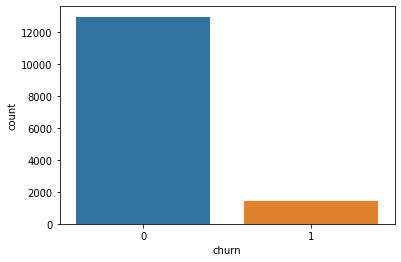

In [22]:
# Checking if the target variable is balanced or not.
sns.countplot(x='churn', data=new_df_ft)
plt.show()

We can see that our target variable is imbalanced, which means that we need to use the "f-1" score as an evaluation metric. This will help us get an accurate idea about the performance of our model.
Using "accuracy" as a metric will result in choosing the wrong model. The "why" behind this statement can be explained by the example of a dummy model that always predicts the most common class. This model will be considered as a good model in an evaluation process where we use "accuracy" as a metric. 


#### 2). Handling outliers :

The way we handle outliers depends on the context. For example, in the case of  datasets where we have an important number of numerical features with a lot of outliers (like in our case), removing the outliers will result in losing a lot of information and capping them will increase the risk of distorting the distribution of the variable or the relationship between variables. 
So the right thing to do in this case is to use models that are robust to outliers such as the Random Forest model.  




In [556]:
# Getting numerical features
cols_num = [col for col in new_df_ft.columns if new_df_ft[col].dtype in ['int64', 'float64']]

boxplot of feature cons_12m
--------------------------------------


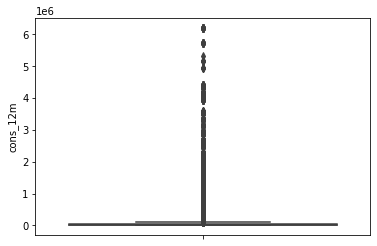

--------------------------------------
boxplot of feature cons_gas_12m
--------------------------------------


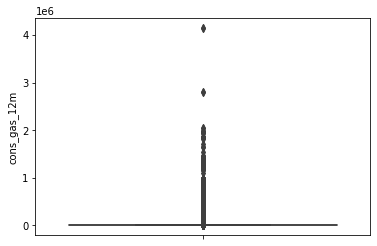

--------------------------------------
boxplot of feature cons_last_month
--------------------------------------


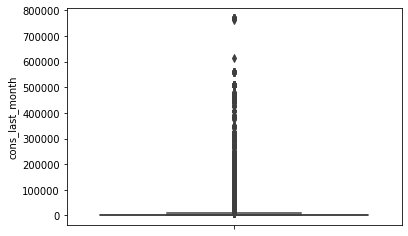

--------------------------------------
boxplot of feature forecast_cons_12m
--------------------------------------


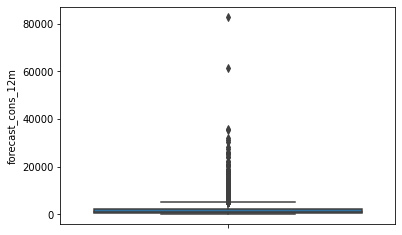

--------------------------------------
boxplot of feature forecast_cons_year
--------------------------------------


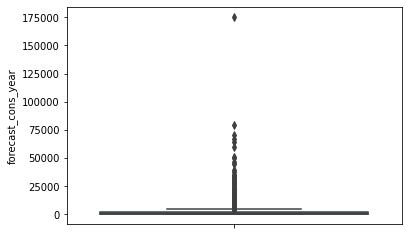

--------------------------------------
boxplot of feature forecast_discount_energy
--------------------------------------


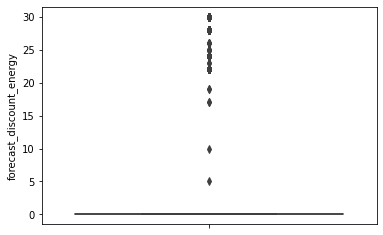

--------------------------------------
boxplot of feature forecast_meter_rent_12m
--------------------------------------


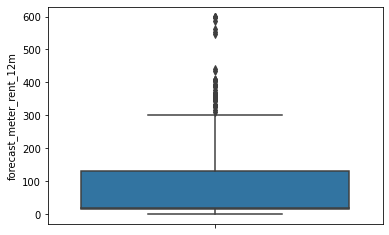

--------------------------------------
boxplot of feature forecast_price_energy_off_peak
--------------------------------------


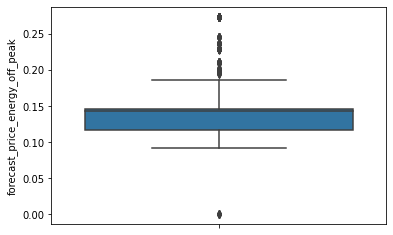

--------------------------------------
boxplot of feature forecast_price_energy_peak
--------------------------------------


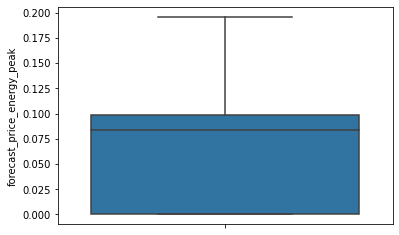

--------------------------------------
boxplot of feature forecast_price_pow_off_peak
--------------------------------------


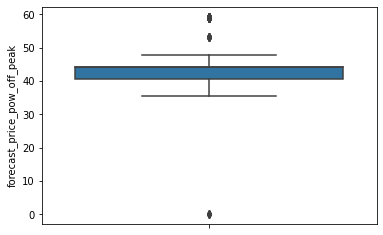

--------------------------------------
boxplot of feature imp_cons
--------------------------------------


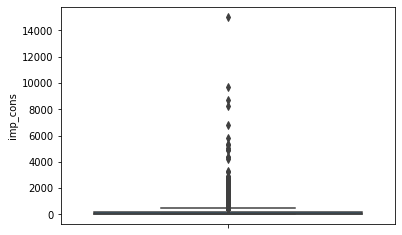

--------------------------------------
boxplot of feature margin_gross_pow_ele
--------------------------------------


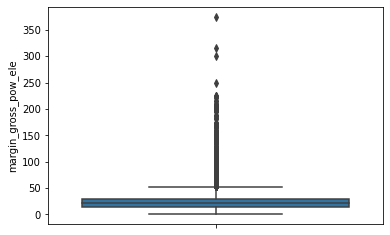

--------------------------------------
boxplot of feature margin_net_pow_ele
--------------------------------------


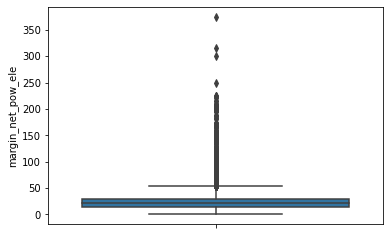

--------------------------------------
boxplot of feature nb_prod_act
--------------------------------------


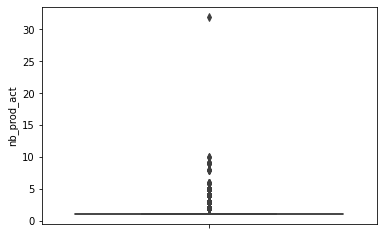

--------------------------------------
boxplot of feature net_margin
--------------------------------------


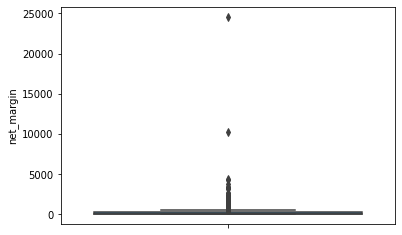

--------------------------------------
boxplot of feature num_years_antig
--------------------------------------


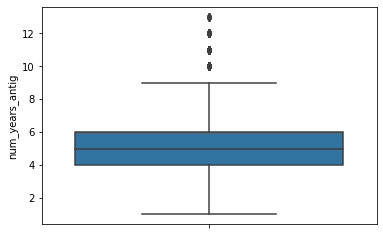

--------------------------------------
boxplot of feature pow_max
--------------------------------------


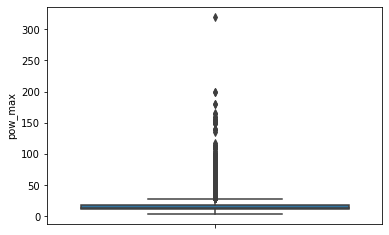

--------------------------------------
boxplot of feature churn
--------------------------------------


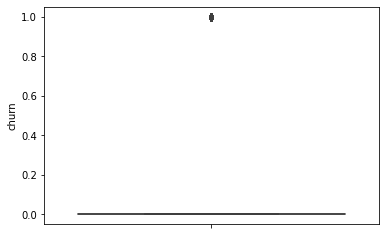

--------------------------------------
boxplot of feature price_off_peak_var
--------------------------------------


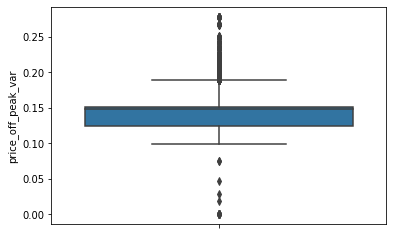

--------------------------------------
boxplot of feature price_peak_var
--------------------------------------


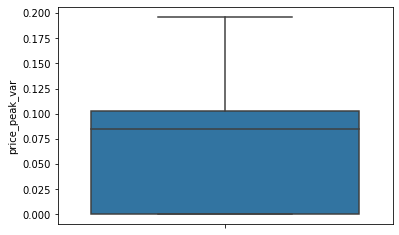

--------------------------------------
boxplot of feature price_mid_peak_var
--------------------------------------


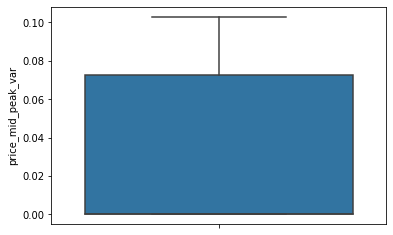

--------------------------------------
boxplot of feature price_off_peak_fix
--------------------------------------


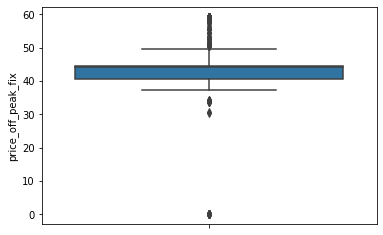

--------------------------------------
boxplot of feature price_peak_fix
--------------------------------------


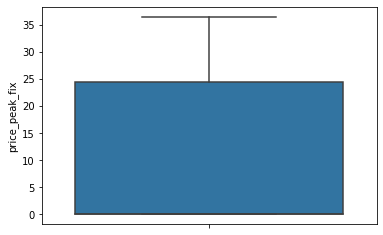

--------------------------------------
boxplot of feature price_mid_peak_fix
--------------------------------------


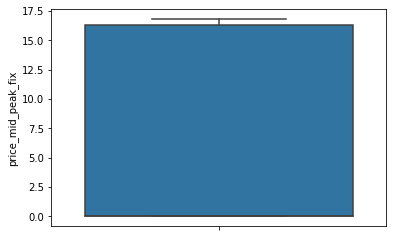

--------------------------------------
boxplot of feature forcasted_price
--------------------------------------


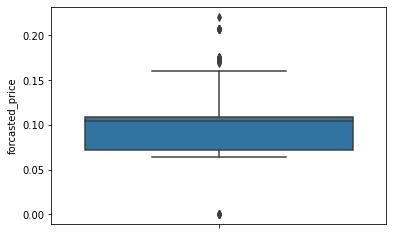

--------------------------------------
boxplot of feature previous_price
--------------------------------------


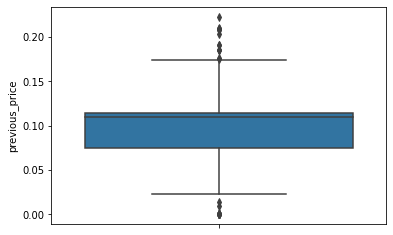

--------------------------------------
boxplot of feature price_sens
--------------------------------------


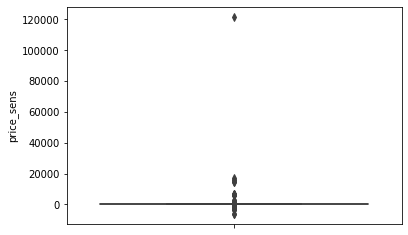

--------------------------------------
boxplot of feature activ_year
--------------------------------------


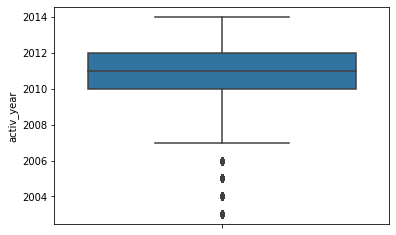

--------------------------------------
boxplot of feature activ_month
--------------------------------------


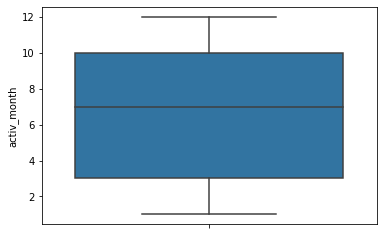

--------------------------------------
boxplot of feature end_year
--------------------------------------


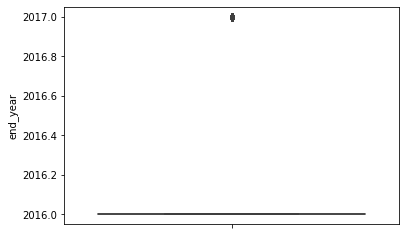

--------------------------------------
boxplot of feature end_month
--------------------------------------


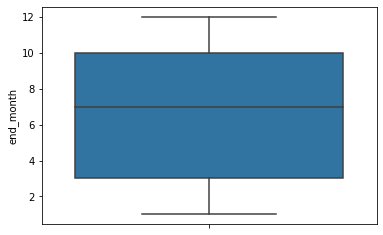

--------------------------------------
boxplot of feature modif_prod_year
--------------------------------------


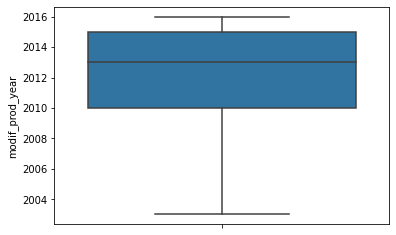

--------------------------------------
boxplot of feature modif_prod_month
--------------------------------------


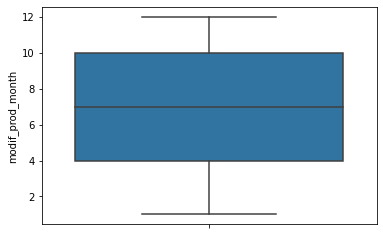

--------------------------------------
boxplot of feature renewal_year
--------------------------------------


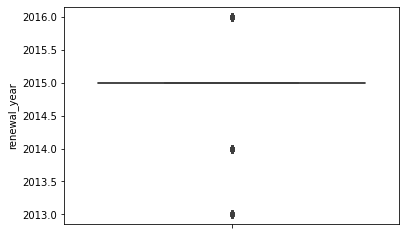

--------------------------------------
boxplot of feature renewal_month
--------------------------------------


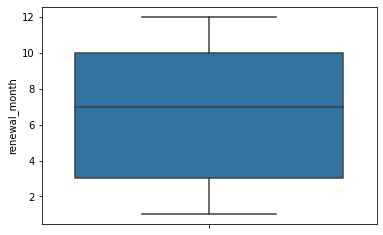

--------------------------------------
boxplot of feature diff_act_renew
--------------------------------------


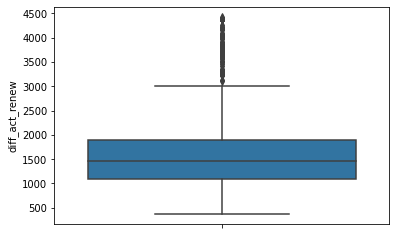

--------------------------------------
boxplot of feature diff_act_end
--------------------------------------


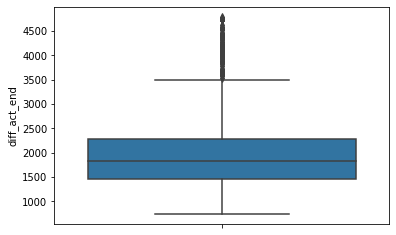

--------------------------------------
boxplot of feature diff_act_modif
--------------------------------------


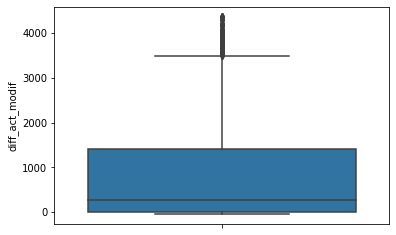

--------------------------------------
boxplot of feature diff_end_modif
--------------------------------------


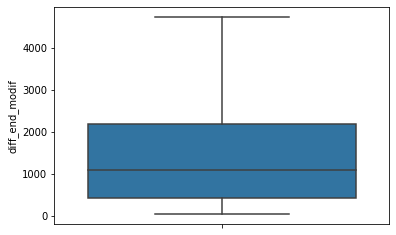

--------------------------------------
boxplot of feature avrg_month_cons
--------------------------------------


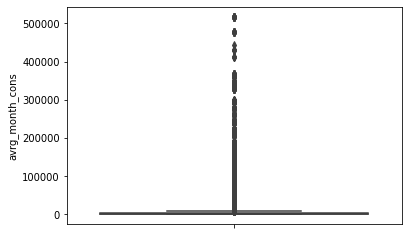

--------------------------------------
boxplot of feature avrg_month_cons_gaz
--------------------------------------


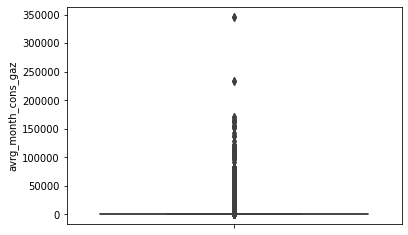

--------------------------------------
boxplot of feature forcast_avrg_month_cons
--------------------------------------


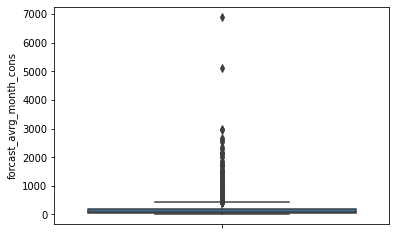

--------------------------------------
boxplot of feature ratio_last_month_last12m_cons
--------------------------------------


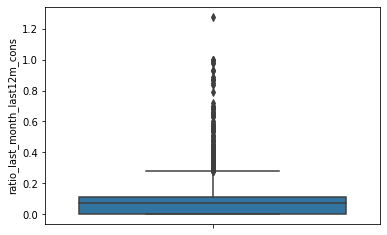

--------------------------------------
boxplot of feature ratio_last_month_avg_cons
--------------------------------------


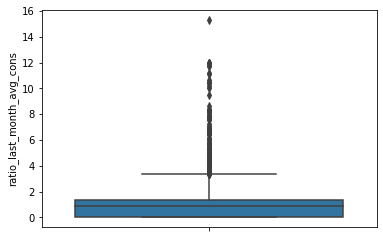

--------------------------------------


In [557]:
for col in cols_num:
    print('boxplot of feature {}'.format(col))
    print('--------------------------------------')
    sns.boxplot(y=col, data=new_df_ft)
    plt.show()
    print('--------------------------------------')

### III. Correlation based feature selection 
We will use the correlation score between features to do feature selection in order to reduce the number of continuous variables.
The selection of features will be based on model performance which is expressed in terms of our evaluation metric "f-1".


In [16]:
# Getting numerical features 
num_ftr = [col for col in new_df_ft.columns if new_df_ft[col].dtype in ['int64', 'float64']]

# Getting datetime features 

date_ftr = [col for col in new_df_ft.columns if new_df_ft[col].dtype == 'datetime64[ns]']

# Getting categorical features 
cat_ftr = [col for col in new_df_ft.columns if col not in num_ftr + date_ftr and col != 'id']

print(len(num_ftr)+len(cat_ftr))
print(len(new_df_ft.columns))

48
53


In [17]:
# Checking the existence of "inf" values
new_df_ft.replace([np.inf, -np.inf], np.nan, inplace=True)

In [18]:
# Dropping "Nan" values that resulted from the feature engineering process
new_df_ft = new_df_ft.dropna()

In [341]:
# Creating an initial feature selection pipeline to eleminate correlated features
sel_1 = SmartCorrelatedSelection(selection_method='model_performance', estimator=RandomForestClassifier(), scoring='f1', cv=5, threshold=0.8)
sel_1.fit(new_df_ft[num_ftr], new_df_ft['churn'])
len(sel_1.features_to_drop_)

21

In [343]:
# Transforming our dataset
df_1 = sel_1.transform(new_df_ft[num_ftr])
df_1.head()

,cons_12m,cons_gas_12m,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,imp_cons,margin_gross_pow_ele,nb_prod_act,net_margin,pow_max,...,previous_price,price_sens,end_year,modif_prod_month,renewal_year,renewal_month,diff_act_end,diff_act_modif,diff_end_modif,ratio_last_month_last12m_cons
1,4660,0,189.95,0.0,16.27,0.00,16.38,1,18.89,13.800,...,0.078366,13.640956,2016,8,2015,8,2566,0,2566,0.000000
2,544,0,47.96,0.0,38.72,0.00,28.60,1,6.60,13.856,...,0.129466,45.058910,2016,4,2015,4,2192,0,2192,0.000000
3,1584,0,240.04,0.0,19.83,0.00,30.22,1,25.46,13.200,...,0.075605,28.408609,2016,3,2015,3,2192,0,2192,0.000000
4,4425,0,445.75,0.0,131.73,52.32,44.91,1,47.98,19.800,...,0.113906,18.799168,2016,1,2015,3,2245,0,2245,0.118870
5,8302,0,796.94,0.0,30.12,181.21,33.12,1,118.89,13.200,...,0.128293,40.841311,2016,11,2015,12,1827,1423,404,0.240665


In [344]:
# Concatenating the dataframes without the "id" and datetime columns
df_full = pd.concat([new_df_ft[cat_ftr], df_1], axis=1)
df_full

,has_gas,origin_up,price_change_energy,price_change_power,cons_12m,cons_gas_12m,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,imp_cons,...,previous_price,price_sens,end_year,modif_prod_month,renewal_year,renewal_month,diff_act_end,diff_act_modif,diff_end_modif,ratio_last_month_last12m_cons
1,f,kamkkxfxxuwbdslkwifmmcsiusiuosws,decrease,increase,4660,0,189.95,0.0,16.27,0.00,...,0.078366,13.640956,2016,8,2015,8,2566,0,2566,0.000000
2,f,kamkkxfxxuwbdslkwifmmcsiusiuosws,decrease,increase,544,0,47.96,0.0,38.72,0.00,...,0.129466,45.058910,2016,4,2015,4,2192,0,2192,0.000000
3,f,kamkkxfxxuwbdslkwifmmcsiusiuosws,decrease,increase,1584,0,240.04,0.0,19.83,0.00,...,0.075605,28.408609,2016,3,2015,3,2192,0,2192,0.000000
4,f,kamkkxfxxuwbdslkwifmmcsiusiuosws,decrease,increase,4425,0,445.75,0.0,131.73,52.32,...,0.113906,18.799168,2016,1,2015,3,2245,0,2245,0.118870
5,f,lxidpiddsbxsbosboudacockeimpuepw,decrease,decrease,8302,0,796.94,0.0,30.12,181.21,...,0.128293,40.841311,2016,11,2015,12,1827,1423,404,0.240665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14537,t,lxidpiddsbxsbosboudacockeimpuepw,decrease,increase,32270,47940,4648.01,0.0,18.57,0.00,...,0.072062,21.198938,2016,5,2014,5,1445,1079,366,0.000000
14538,f,lxidpiddsbxsbosboudacockeimpuepw,decrease,increase,7223,0,631.69,0.0,144.03,15.94,...,0.101103,18.186301,2016,8,2015,8,1461,0,1461,0.025059
14539,f,lxidpiddsbxsbosboudacockeimpuepw,decrease,increase,1844,0,190.39,0.0,129.60,18.05,...,0.114066,18.237929,2016,2,2015,2,1460,0,1460,0.097072
14540,f,lxidpiddsbxsbosboudacockeimpuepw,decrease,increase,131,0,19.34,0.0,7.18,0.00,...,0.078366,12.121174,2016,8,2015,8,1461,0,1461,0.000000


In [345]:
# Getting the target 'churn'
y = df_full.pop('churn')
y

1        0
2        0
3        0
4        0
5        1
        ..
14537    0
14538    1
14539    1
14540    0
14541    0
Name: churn, Length: 14340, dtype: int64

In [357]:
# Splitting the dataset into train and test sets
train_X, test_X, train_y, test_y = train_test_split(df_full, y, test_size=0.30)
print(len(train_X), len(test_X), len(train_y), len(test_y))

10038 4302 10038 4302


In [358]:
# Getting the names of the features after the first phase of feature selection 
# Getting numerical features 
num_ftr = [col for col in df_full.columns if df_full[col].dtype in ['int64', 'float64']]

# Getting datetime features 

date_ftr = [col for col in df_full.columns if df_full[col].dtype == 'datetime64[ns]']

# Getting categorical features 
cat_ftr = [col for col in df_full.columns if col not in num_ftr + date_ftr and col != 'id']

print(len(num_ftr)+len(cat_ftr))
print(len(new_df_ft.columns))

26
53


### IV. Tuning and training the Random Forest model.

#### 1). The reasons why Random Forest is a good choice for our case.

The reasons why Random forest is a good choice are :

- Having an important number of features (like the case of our dataset) can increase the complexity of the model which may cause the problem of overfitting the dataset. Random forest, which is a bagging algorithm will be  a good choice for our dataset because bagging algorithms tend to reduce variance (overfitting).

- It is a good choice because it can handle outliers for the reason that decision trees are robust to outliers because they make decisions by asking if a variable x is >= than a certain value, and therefore the outlier will fall on one of the sides of the equation.

The main disadvantage of random forest models is the large inference time which makes the model slow when doing predictions.


#### 2). Tuning and training the model

In [349]:
# A function to fit and tune Random Forest

def objective(trial):
    
    # Defining the scalers space 
    scalers = trial.suggest_categorical('scalers', ['minmax', 'standard', 'robust'])
    if scalers == 'minmax':
        scaler = MinMaxScaler()
    elif scalers == 'robust':
        scaler = RobustScaler()
    else:
        scaler = StandardScaler()
    
    # Defining the encoder space
    encoders = trial.suggest_categorical('encoders', ['Ordinal', 'OneHot', 'Count', 'Mean', 'PRatio'])
    if encoders == "Ordinal":
        encoder = OrdinalEncoder()
    elif encoders == 'OneHot':
        encoder = OneHotEncoder()
    elif encoders == "Count":
        encoder = CountFrequencyEncoder()
    elif encoders == 'Mean':
        encoder = MeanEncoder()
    else :
        encoder = PRatioEncoder()
    
    # Defining the n_estimators space
    n_estims = trial.suggest_int('n_estimators', low=20, high=400)
    
    # Defining the max_depth space
    max_dep = trial.suggest_int('max_depth', low=2, high=14)

    # Defining the number of features space for the second phase of feature selection using mutual inforamtion selector
    k = trial.suggest_int('k', low=5, high=len(train_X.columns))
        
    # Preprocessing steps for the numerical variables
    num_preproc = Pipeline(steps=[('scaler',scaler)])

    # Preprocessing steps for the categorical variables
    cat_preproc = Pipeline(steps=[('encoder', encoder)])

    preprocessor = ColumnTransformer(transformers=[('numerical_preprocessor',num_preproc, num_ftr),
                                               ('cat_preprocessor', cat_preproc, cat_ftr)])

    model_pipe = Pipeline(steps=[("preprocessing", preprocessor),
                                 ('selector', SelectKBest(mutual_info_classif, k=k)),
                                 ("model", RandomForestClassifier(n_estimators=n_estims, max_depth=max_dep, max_features=None))])
    
    cv_score = cross_val_score(model_pipe, train_X, train_y, cv=5, scoring ='f1').mean()
    
    return cv_score

study_1 = optuna.create_study(direction='maximize')
study_1.optimize(objective, n_trials=200, show_progress_bar=True)
    


[I 2022-11-07 22:24:23,896] A new study created in memory with name: no-name-2ed35ba7-b223-422f-ab69-f7950ec3ee84
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2022-11-07 22:25:46,724] Trial 0 finished with value: 0.02000050001250031 and parameters: {'scalers': 'standard', 'encoders': 'PRatio', 'n_estimators': 59, 'max_depth': 6, 'k': 21}. Best is trial 0 with value: 0.02000050001250031.
[I 2022-11-07 22:29:56,720] Trial 1 finished with value: 0.08001219496421315 and parameters: {'scalers': 'robust', 'encoders': 'PRatio', 'n_estimators': 157, 'max_depth': 13, 'k': 19}. Best is trial 1 with value: 0.08001219496421315.
[I 2022-11-07 22:34:40,034] Trial 2 finished with value: 0.019491995314330338 and parameters: {'scalers': 'standard', 'encoders': 'Count', 'n_estimators': 368, 'max_depth': 8, 'k': 13}. Best is trial 1 with value: 0.08001219496421315.
[I 2022-11-07 22:38:05,982] Trial 3 finished with value: 0.0040405071040481595 and parameters: {'scalers': 'minmax', 'encoders': 'Mean', 'n_estimators': 375, 'max_depth': 8, 'k': 10}. Best is trial 1 with value: 0.08001219496421315.
[I 2022-11-07 22:42:06,856] Trial 4 finished with value: 0.04516

In [350]:
study_1.best_params

{'scalers': 'minmax',
 'encoders': 'Count',
 'n_estimators': 180,
 'max_depth': 14,
 'k': 24}

In [353]:
# Training the model with the found parameters 

 # Preprocessing steps for the numerical variables
num_preproc = Pipeline(steps=[('scaler',MinMaxScaler())])

# Preprocessing steps for the categorical variables
cat_preproc = Pipeline(steps=[('encoder', CountFrequencyEncoder())])

preprocessor = ColumnTransformer(transformers=[('numerical_preprocessor',num_preproc, num_ftr),
                                               ('cat_preprocessor', cat_preproc, cat_ftr)])

model_pipe = Pipeline(steps=[("preprocessing", preprocessor),
                                 ('selector', SelectKBest(mutual_info_classif, k=24)),
                                 ("model", RandomForestClassifier(n_estimators=180, max_depth=14, max_features=None))])

In [354]:
model_pipe.fit(train_X, train_y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical_preprocessor',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['cons_12m', 'cons_gas_12m',
                                                   'forecast_cons_12m',
                                                   'forecast_discount_energy',
                                                   'forecast_meter_rent_12m',
                                                   'imp_cons',
                                                   'margin_gross_pow_ele',
                                                   'nb_prod_act', 'net_margin',
                                                   'pow_max',
                                                   'price_off_peak_var',
                                                   'price_off_peak

#### 3). Evaluation of the model

In [359]:
# The classification report of the model

print(classification_report(test_y, model_pipe.predict(test_X)))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97      3876
           1       0.99      0.36      0.53       426

    accuracy                           0.94      4302
   macro avg       0.96      0.68      0.75      4302
weighted avg       0.94      0.94      0.92      4302



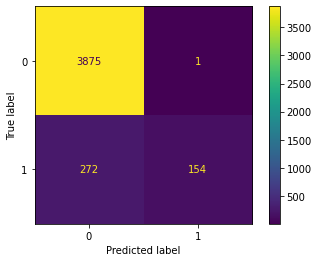

In [360]:
# Visualizing the confusion matrix 

cfm=confusion_matrix(test_y, model_pipe.predict(test_X))
ConfusionMatrixDisplay(cfm).plot()


Given the information at hand, the model was able to predict 154 cases of churn out of 426 cases in the test set which represents 36% of the cases.\nWe think that the performance of the model is satisfactory since it's macro F1 score is larger than 0.7 which is a decent score in the case of a very imbalanced dataset.


In [364]:
# Getting the names of the selected features

# The selector object
selector = model_pipe[1]

# The indices of the features
indx = selector.get_support(indices=True)

select_ftr = df_full.columns[indx]
print(select_ftr)

Index(['has_gas', 'origin_up', 'price_change_energy', 'cons_12m',
       'forecast_cons_12m', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'imp_cons', 'margin_gross_pow_ele',
       'nb_prod_act', 'net_margin', 'pow_max', 'price_off_peak_var',
       'price_off_peak_fix', 'previous_price', 'price_sens', 'end_year',
       'modif_prod_month', 'renewal_year', 'renewal_month', 'diff_act_end',
       'diff_act_modif', 'diff_end_modif', 'ratio_last_month_last12m_cons'],
      dtype='object')


In [365]:
# The new dataframe with the selected features 
final_df = df_full[select_ftr]
final_df

,has_gas,origin_up,price_change_energy,cons_12m,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,imp_cons,margin_gross_pow_ele,nb_prod_act,...,previous_price,price_sens,end_year,modif_prod_month,renewal_year,renewal_month,diff_act_end,diff_act_modif,diff_end_modif,ratio_last_month_last12m_cons
1,f,kamkkxfxxuwbdslkwifmmcsiusiuosws,decrease,4660,189.95,0.0,16.27,0.00,16.38,1,...,0.078366,13.640956,2016,8,2015,8,2566,0,2566,0.000000
2,f,kamkkxfxxuwbdslkwifmmcsiusiuosws,decrease,544,47.96,0.0,38.72,0.00,28.60,1,...,0.129466,45.058910,2016,4,2015,4,2192,0,2192,0.000000
3,f,kamkkxfxxuwbdslkwifmmcsiusiuosws,decrease,1584,240.04,0.0,19.83,0.00,30.22,1,...,0.075605,28.408609,2016,3,2015,3,2192,0,2192,0.000000
4,f,kamkkxfxxuwbdslkwifmmcsiusiuosws,decrease,4425,445.75,0.0,131.73,52.32,44.91,1,...,0.113906,18.799168,2016,1,2015,3,2245,0,2245,0.118870
5,f,lxidpiddsbxsbosboudacockeimpuepw,decrease,8302,796.94,0.0,30.12,181.21,33.12,1,...,0.128293,40.841311,2016,11,2015,12,1827,1423,404,0.240665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14537,t,lxidpiddsbxsbosboudacockeimpuepw,decrease,32270,4648.01,0.0,18.57,0.00,27.88,2,...,0.072062,21.198938,2016,5,2014,5,1445,1079,366,0.000000
14538,f,lxidpiddsbxsbosboudacockeimpuepw,decrease,7223,631.69,0.0,144.03,15.94,0.00,1,...,0.101103,18.186301,2016,8,2015,8,1461,0,1461,0.025059
14539,f,lxidpiddsbxsbosboudacockeimpuepw,decrease,1844,190.39,0.0,129.60,18.05,39.84,1,...,0.114066,18.237929,2016,2,2015,2,1460,0,1460,0.097072
14540,f,lxidpiddsbxsbosboudacockeimpuepw,decrease,131,19.34,0.0,7.18,0.00,13.08,1,...,0.078366,12.121174,2016,8,2015,8,1461,0,1461,0.000000


In [366]:
# Getting the trained model 
clf = model_pipe[-1]
clf

RandomForestClassifier(max_depth=14, max_features=None, n_estimators=180)

In [367]:
# Saving the model
filename = 'best_model_PowerCo.sav'
pickle.dump(clf, open(filename, 'wb'))

In [369]:
# Saving the study 
pickle.dump(study_1, open('optuna_study_PowerCo.sav', 'wb'))

In [370]:
# # Getting the names of the features after the second phase of feature selection 
# Getting numerical features 
num_ftr = [col for col in final_df.columns if final_df[col].dtype in ['int64', 'float64']]

# Getting categorical features 
cat_ftr = [col for col in final_df.columns if col not in num_ftr + date_ftr and col != 'id']

print(len(num_ftr)+len(cat_ftr))

24


### V. Model interpretation using SHAP
SHAP is a technique used to interpret machine learning models. It explains a prediction by calculating what are known as Shapley values, which were developed in Game Theory. These values represent the contributions of the different explanatory variables to the prediction in question.

In [20]:
# Getting the full dataframe with the selected features.
df_int = new_df_ft[select_ftr]

In [559]:
# Getting the train_X and test_X with the selected features 
new_train_X = train_X[select_ftr]
new_test_X = test_X[select_ftr]
new_train_X

,has_gas,origin_up,price_change_energy,cons_12m,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,imp_cons,margin_gross_pow_ele,nb_prod_act,...,previous_price,price_sens,end_year,modif_prod_month,renewal_year,renewal_month,diff_act_end,diff_act_modif,diff_end_modif,ratio_last_month_last12m_cons
7835,f,lxidpiddsbxsbosboudacockeimpuepw,decrease,62623,5636.69,0.0,129.60,405.53,13.76,1,...,0.113567,18.190599,2016,1,2015,3,1461,1401,60,0.073535
7058,f,kamkkxfxxuwbdslkwifmmcsiusiuosws,decrease,24673,3650.39,0.0,0.00,0.00,4.83,1,...,0.073848,41.060672,2016,11,2015,12,2557,0,2557,0.000000
935,f,ldkssxwpmemidmecebumciepifcamkci,decrease,2339,227.88,0.0,131.77,21.80,22.44,1,...,0.112147,17.713324,2016,7,2015,8,2557,2163,394,0.097050
11893,f,lxidpiddsbxsbosboudacockeimpuepw,decrease,5973,388.97,0.0,0.00,67.84,24.62,1,...,0.074933,24.044035,2016,11,2015,12,1461,1059,402,0.178302
3007,f,lxidpiddsbxsbosboudacockeimpuepw,decrease,2059,260.77,0.0,14.34,18.33,14.53,1,...,0.127125,-2716.204844,2016,9,2015,9,1481,750,731,0.073822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,f,lxidpiddsbxsbosboudacockeimpuepw,decrease,1251,119.55,0.0,146.53,7.33,49.44,1,...,0.114066,18.394221,2016,2,2015,2,1461,0,1461,0.062350
9554,t,lxidpiddsbxsbosboudacockeimpuepw,decrease,44785,4509.22,0.0,130.31,328.55,1.59,2,...,0.112963,19.230034,2016,11,2015,12,2192,1437,755,0.076008
5079,f,lxidpiddsbxsbosboudacockeimpuepw,decrease,3819,573.00,0.0,18.72,0.00,33.12,1,...,0.075014,17.281933,2016,12,2015,2,2191,2144,47,0.000000
10947,f,ldkssxwpmemidmecebumciepifcamkci,decrease,42144,3860.98,0.0,131.37,44.32,21.16,1,...,0.112523,18.525477,2016,6,2015,6,2557,0,2557,0.011698


In [21]:
# Scaling numerical features 
scaler = SklearnTransformerWrapper(MinMaxScaler())
df_int = scaler.fit_transform(df_int)
df_int

,has_gas,origin_up,price_change_energy,cons_12m,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,imp_cons,margin_gross_pow_ele,nb_prod_act,...,previous_price,price_sens,end_year,modif_prod_month,renewal_year,renewal_month,diff_act_end,diff_act_modif,diff_end_modif,ratio_last_month_last12m_cons
1,f,kamkkxfxxuwbdslkwifmmcsiusiuosws,decrease,0.000751,0.002291,0.0,0.027148,0.000000,0.043722,0.000000,...,0.351456,0.050352,0.0,0.636364,0.666667,0.636364,0.451526,0.012884,0.537402,0.000000
2,f,kamkkxfxxuwbdslkwifmmcsiusiuosws,decrease,0.000087,0.000579,0.0,0.064608,0.000000,0.076340,0.000000,...,0.580630,0.050598,0.0,0.272727,0.666667,0.272727,0.359498,0.012884,0.458148,0.000000
3,f,kamkkxfxxuwbdslkwifmmcsiusiuosws,decrease,0.000255,0.002895,0.0,0.033088,0.000000,0.080664,0.000000,...,0.339073,0.050468,0.0,0.181818,0.666667,0.181818,0.359498,0.012884,0.458148,0.000000
4,f,kamkkxfxxuwbdslkwifmmcsiusiuosws,decrease,0.000713,0.005377,0.0,0.219803,0.003478,0.119875,0.000000,...,0.510846,0.050393,0.0,0.000000,0.666667,0.181818,0.372539,0.012884,0.469379,0.093135
5,f,lxidpiddsbxsbosboudacockeimpuepw,decrease,0.001337,0.009613,0.0,0.050258,0.012046,0.088405,0.000000,...,0.575366,0.050565,0.0,0.909091,0.666667,1.000000,0.269685,0.334539,0.079254,0.188562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14537,t,lxidpiddsbxsbosboudacockeimpuepw,decrease,0.005199,0.056066,0.0,0.030986,0.000000,0.074418,0.032258,...,0.323184,0.050411,0.0,0.363636,0.333333,0.363636,0.175689,0.256781,0.071202,0.000000
14538,f,lxidpiddsbxsbosboudacockeimpuepw,decrease,0.001164,0.007620,0.0,0.240326,0.001060,0.000000,0.000000,...,0.453424,0.050388,0.0,0.636364,0.666667,0.636364,0.179626,0.012884,0.303242,0.019634
14539,f,lxidpiddsbxsbosboudacockeimpuepw,decrease,0.000297,0.002297,0.0,0.216249,0.001200,0.106342,0.000000,...,0.511562,0.050388,0.0,0.090909,0.666667,0.090909,0.179380,0.012884,0.303030,0.076056
14540,f,lxidpiddsbxsbosboudacockeimpuepw,decrease,0.000021,0.000233,0.0,0.011980,0.000000,0.034914,0.000000,...,0.351456,0.050341,0.0,0.636364,0.666667,0.636364,0.179626,0.012884,0.303242,0.000000


In [22]:
# Encoding categorical features 
enc = CountFrequencyEncoder()
df_int = enc.fit_transform(df_int)
df_int

,has_gas,origin_up,price_change_energy,cons_12m,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,imp_cons,margin_gross_pow_ele,nb_prod_act,...,previous_price,price_sens,end_year,modif_prod_month,renewal_year,renewal_month,diff_act_end,diff_act_modif,diff_end_modif,ratio_last_month_last12m_cons
1,11728,4272,13702,0.000751,0.002291,0.0,0.027148,0.000000,0.043722,0.000000,...,0.351456,0.050352,0.0,0.636364,0.666667,0.636364,0.451526,0.012884,0.537402,0.000000
2,11728,4272,13702,0.000087,0.000579,0.0,0.064608,0.000000,0.076340,0.000000,...,0.580630,0.050598,0.0,0.272727,0.666667,0.272727,0.359498,0.012884,0.458148,0.000000
3,11728,4272,13702,0.000255,0.002895,0.0,0.033088,0.000000,0.080664,0.000000,...,0.339073,0.050468,0.0,0.181818,0.666667,0.181818,0.359498,0.012884,0.458148,0.000000
4,11728,4272,13702,0.000713,0.005377,0.0,0.219803,0.003478,0.119875,0.000000,...,0.510846,0.050393,0.0,0.000000,0.666667,0.181818,0.372539,0.012884,0.469379,0.093135
5,11728,7009,13702,0.001337,0.009613,0.0,0.050258,0.012046,0.088405,0.000000,...,0.575366,0.050565,0.0,0.909091,0.666667,1.000000,0.269685,0.334539,0.079254,0.188562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14537,2612,7009,13702,0.005199,0.056066,0.0,0.030986,0.000000,0.074418,0.032258,...,0.323184,0.050411,0.0,0.363636,0.333333,0.363636,0.175689,0.256781,0.071202,0.000000
14538,11728,7009,13702,0.001164,0.007620,0.0,0.240326,0.001060,0.000000,0.000000,...,0.453424,0.050388,0.0,0.636364,0.666667,0.636364,0.179626,0.012884,0.303242,0.019634
14539,11728,7009,13702,0.000297,0.002297,0.0,0.216249,0.001200,0.106342,0.000000,...,0.511562,0.050388,0.0,0.090909,0.666667,0.090909,0.179380,0.012884,0.303030,0.076056
14540,11728,7009,13702,0.000021,0.000233,0.0,0.011980,0.000000,0.034914,0.000000,...,0.351456,0.050341,0.0,0.636364,0.666667,0.636364,0.179626,0.012884,0.303242,0.000000


In [23]:
# Importing the classifier
model = pickle.load(open('best_model_PowerCo.sav', 'rb'))
model

RandomForestClassifier(max_depth=14, max_features=None, n_estimators=180)

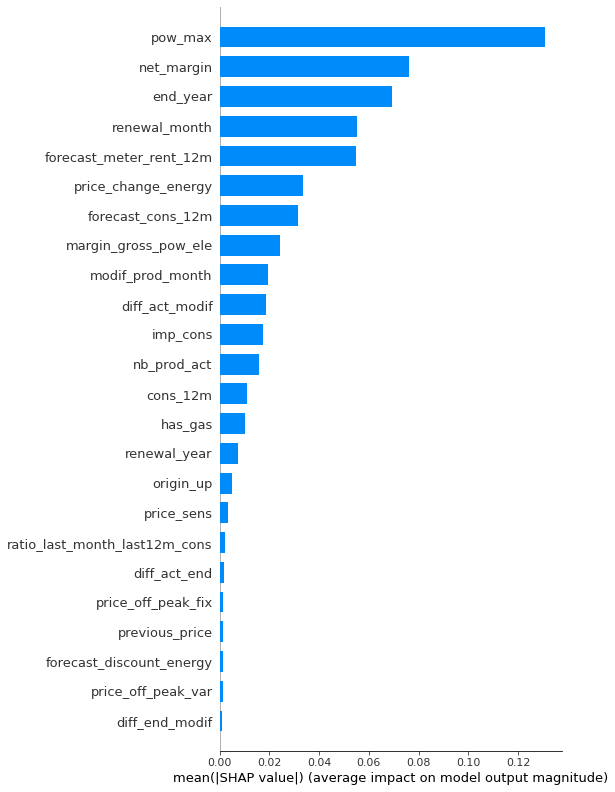

In [24]:
# The code to get shap values 
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_int)

# Plotting feature importance 
shap.summary_plot(shap_values[0], df_int, max_display=26, plot_type='bar')


We can see from the visual above  that the three most important features for the model are "pow_max" which indicates the subscribed power, the net margin and "end_year" which indicates the registered year of the end of the contract.


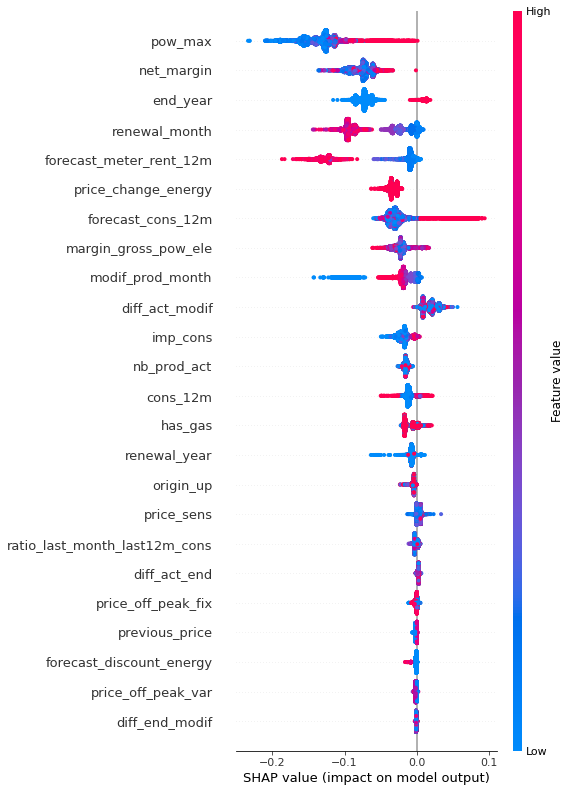

In [26]:
# Investigating the global effect of each feature on the model output(pushing it down or up).
shap.summary_plot(shap_values[0], df_int, max_display=26)

From this visual we can conclude that:

- High subscribed power increases the chances of the clients to churn (impacts negatively the output of the model, pushing it towards zero) this may be a signal that large clients are not satisfied with  the prices that they are paying given the large quantities they are buying, which means that there are other companies giving them better prices. Another signal that the company is suffering from an exodus of it's big clients is that higher values of the feature forcast_cons_12m push the model to predict a churning client.

- The churn is mainly driven by price related variables, since the decrease in the price energy during the previous year expressed using the feature "price_change_energy" decreases the chances of the clients leaving the company (this feature is categorical and was encoded using "counting" the category "decrease" has the highest value this why we see in the visual that large values of this feature impact the output of model negatively).

- The clients that have a gas contract with the company are less likely to churn (according to the encoding of this feature "f" means high value and "t" means small value).




In [30]:
# The encoding of categorical features that may help us interpret the model.
enc.encoder_dict_

{'has_gas': {'f': 11728, 't': 2612},
 'origin_up': {'lxidpiddsbxsbosboudacockeimpuepw': 7009,
  'kamkkxfxxuwbdslkwifmmcsiusiuosws': 4272,
  'ldkssxwpmemidmecebumciepifcamkci': 3056,
  'Rare': 3},
 'price_change_energy': {'decrease': 13702, 'increase': 625, 'stable': 13}}